In [1]:
import os
import sys
import time
import numpy as np
import tifffile as tiff
from PIL import Image
import matplotlib.pyplot as plt

sys.path.insert(0, '../')
%load_ext autoreload
%autoreload 2
from srcv2_2.models.Unet import UnetV2
from srcv2_2.models.params import get_params
from srcv2_2.utils import CategoryIndexOrder, load_product, get_cls, extract_collapsed_cls, extract_cls_mask, predict_img, image_normalizer, get_model_name
from srcv2_2.models.evaluate_model import calculate_evaluation_criteria, calculate_class_evaluation_criteria

import tensorflow as tf
import tensorflow.keras as keras

2024-05-01 15:58:04.949581: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-01 15:58:04.967781: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 15:58:04.967795: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 15:58:04.968323: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-01 15:58:04.971529: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# params
params = get_params('U-net-v2', 'MODIS')
params.satellite = 'MODIS'
params.cls = ['cloud', 'thin', 'clear', 'shadow']#['clear', 'shadow', 'thin', 'cloud']#  #'clear', 'cloud', 'shadow', 'snow', 'water'] 

#working edition: ['cloud', 'thin']
params.collapse_cls = False
params.project_path = "/home/mxh/RS-Net/"
params.activation_func='elu'
params.last_layer_activation_func = 'softmax'
params.loss_func="categorical_crossentropy"
params.learning_rate = 1e-7
params.epochs = 8
params.threshold = 0.5
params.dropout = 0 # 0.2
params.dropout_on_last_layer_only = True
params.L2reg = 1e-4
params.decay = 0.0
params.num_gpus = 1
params.overlap = 40
params.modelID = f"_v2_overlap40_mc_cloud-thin-clear-shadow_Last-Layer-softmax_v12_lr-{params.learning_rate}_L2reg-{params.L2reg}_dropout-{params.dropout}_epochs-{params.epochs}"
params.norm_threshold = 16000 # valid range -100 - 16000 in MOD09 doc

In [3]:
# load model
local_loaded_model = tf.keras.saving.load_model(f"../models/Unet/{get_model_name(params)}.keras")
# weights and funcs will automatically be loaded

unet_loaded_local_model = UnetV2(params, model=local_loaded_model)

2024-05-01 15:58:07.466457: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 15:58:07.485975: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-01 15:58:07.486058: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
# use product from test block (params.py)
folder = 'Barren'
product = 'LC81390292014135LGN00'
data_path = params.project_path + "data/raw/Biome_dataset/" + folder + "/BC/" + product + "/"
toa_path = params.project_path + "data/processed/Biome_TOA/" + folder + "/BC/" + product + "/"


In [5]:
params.satellite = 'Landsat8' # quick fix
img, img_rgb, valid_pixels_mask = load_product(product, params, data_path, toa_path)

In [6]:
n_bands = 7
n_cls = 4

# do prediction one test image(s)
prediction_time_start = time.time()
predicted_mask, _ = predict_img(unet_loaded_local_model, params, img, n_bands, n_cls, 1)

2024-05-01 15:58:16.605704: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800


3/3 [==============================] - 2s 869ms/step


In [7]:
predicted_mask.shape

(7901, 7781, 4)

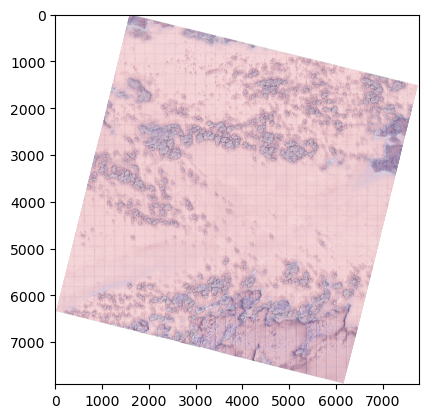

In [8]:
plt.imshow(predicted_mask)

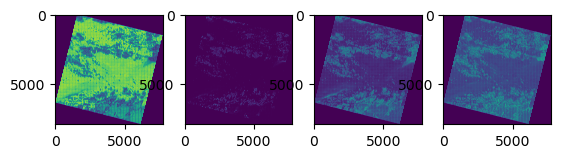

In [9]:
# new
fig, axes = plt.subplots(1,4)

for i, ax in enumerate(axes.flat):
    ax.imshow(predicted_mask[:,:,i])

In [10]:
# Load the true classification mask
mask_true = tiff.imread(data_path + product + '_fixedmask.TIF')  # The 30 m is the native resolution

In [11]:
mask_true.max()

255

In [12]:
mask_true.shape

(7901, 7781)

In [13]:
params.cls

['cloud', 'thin', 'clear', 'shadow']

In [14]:
# Get the masks
cls = get_cls('Landsat8', 'Biome_gt', params.cls)  # this is sorted

In [17]:
true_mask_modified = mask_true.copy()
# this is bugged
for l, c in enumerate(cls):
    y = extract_cls_mask(true_mask_modified, c)
    # Save the binary masks as one hot representations
    true_mask_modified[:, :, l] = y[:, :, 1]

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [15]:
cls

[255, 192, 128, 64]

In [36]:
# convert mask_true to predicted values
mask_true_cls_corrected = mask_true.copy()

cio = CategoryIndexOrder.CLOUD

for l, c in enumerate(params.cls):
    mask_true_cls_corrected[mask_true_cls_corrected == cls[l]] = cio.get_model_index_for_string(params.cls, c)  # hardcode this with some enum of sorts

In [37]:
type(mask_true_cls_corrected)

numpy.ndarray

In [17]:
mask_true = np.uint8(mask_true)
#mask_true_cls_corrected = np.uint8(mask_true_cls_corrected)

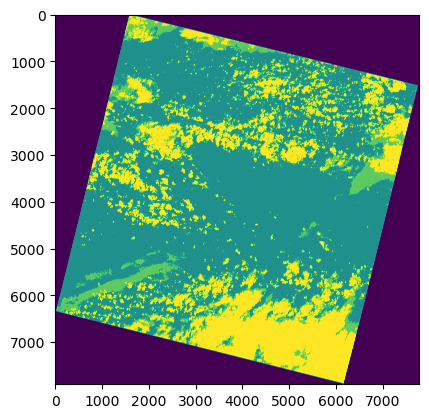

In [18]:
plt.imshow(mask_true)

In [19]:
threshold = 0.5
predicted_binary_mask = np.uint8(predicted_mask >= threshold)

### Eval

In [21]:
accuracy, omission, comission, pixel_jaccard, precision, recall, f_one_score, tp, tn, fp, fn, npix = calculate_evaluation_criteria(
    valid_pixels_mask, predicted_binary_mask, mask_true)

In [22]:
accuracy

0.15435141711717884

In [23]:
accuracy, omission, comission, pixel_jaccard, precision, recall, f_one_score, tp, tn, fp, fn, npix = calculate_evaluation_criteria(
    valid_pixels_mask, predicted_binary_mask, mask_true_cls_corrected)

TypeError: ufunc 'bitwise_and' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [24]:
predicted_mask[:,:,3]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [25]:
categorical_acc = 0
#for c in cls:
    #c_accuracy = ...
#categorical_accuracy = # of correctly predicted records / total number of records


# argmax over predicted masks
# convert index to type
# see if index-type corresponds to true_mask category type -> if yes, considered accurate

argmaxed_pred_mask = np.argmax(predicted_mask, axis=-1)

binary_accuracy_mask = argmaxed_pred_mask == mask_true_cls_corrected
binary_accuracy_mask &= np.asarray(valid_pixels_mask, dtype=bool) # remote invalid pixel
equal_count=np.sum(binary_accuracy_mask)

In [26]:
equal_count

28925446

In [27]:
valid_pixels_mask.sum()

40539414

In [28]:
np.asarray(valid_pixels_mask, dtype=bool)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [29]:
#categorical accuracy 
equal_count / np.asarray(valid_pixels_mask, dtype=bool).sum()

0.7135141617981947

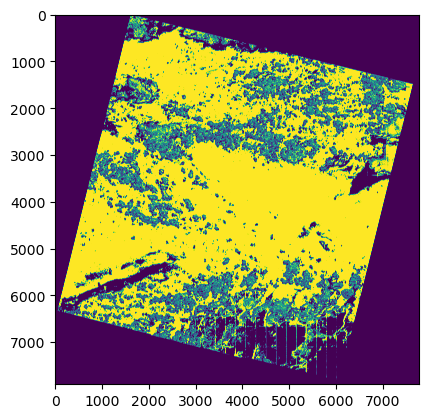

In [30]:
plt.imshow(binary_accuracy_mask)

In [84]:
res = calculate_class_evaluation_criteria(params.cls, cls, valid_pixels_mask, predicted_mask, mask_true_cls_corrected)

In [85]:
res

(0.7135141617981947,
 0.7624849732657705,
 0.10116125764887504,
 0.01917851230065971,
 0.3762124336676018,
 0.8988387423511249,
 0.39284610167363465,
 0.5467359899735782,
 5807176,
 25103518,
 653578,
 8975142,
 40539414)

In [35]:
type(argmaxed_pred_mask)

numpy.ndarray

# more metrics

In [56]:
#cloudy types
positives_mask = [CategoryIndexOrder.THIN, CategoryIndexOrder.CLOUD, CategoryIndexOrder.SHADOW]

#non-cloudy types
negatives_mask = [CategoryIndexOrder.CLEAR, CategoryIndexOrder.SNOW, CategoryIndexOrder.WATER]


In [48]:
pred_num_cloud = np.count_nonzero(argmaxed_pred_mask == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.CLOUD))
pred_num_thin = np.count_nonzero(argmaxed_pred_mask == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.THIN))
pred_num_shadow = np.count_nonzero(argmaxed_pred_mask == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.SHADOW))
pred_num_positives = pred_num_cloud+pred_num_thin+pred_num_shadow

In [53]:
pred_num_clear = np.count_nonzero(argmaxed_pred_mask == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.CLEAR))
#pred_num_snow= np.count_nonzero(argmaxed_pred_mask == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.SNOW))
#pred_num_water = np.count_nonzero(argmaxed_pred_mask == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.WATER))
pred_num_negatives = pred_num_clear

In [54]:
true_num_cloud = np.count_nonzero(mask_true_cls_corrected == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.CLOUD))
true_num_thin = np.count_nonzero(mask_true_cls_corrected == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.THIN))
true_num_shadow = np.count_nonzero(mask_true_cls_corrected == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.SHADOW))
true_num_positives = true_num_cloud+true_num_thin+true_num_shadow

In [55]:
true_num_clear = np.count_nonzero(mask_true_cls_corrected == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.CLEAR))
#pred_num_snow= np.count_nonzero(argmaxed_pred_mask == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.SNOW))
#pred_num_water = np.count_nonzero(argmaxed_pred_mask == cio.get_model_index_for_type(params.cls, CategoryIndexOrder.WATER))
true_num_negatives = true_num_clear

In [59]:
# only positives

tp = ((np.isin(argmaxed_pred_mask, positives_mask) & np.isin(mask_true_cls_corrected, positives_mask)) & valid_pixels_mask).sum()
fp = ((np.isin(argmaxed_pred_mask, positives_mask) & (1 - np.isin(mask_true_cls_corrected, positives_mask))) & valid_pixels_mask).sum()
fn = (((1 - np.isin(argmaxed_pred_mask, positives_mask) & np.isin(mask_true_cls_corrected, positives_mask))) & valid_pixels_mask).sum()
#tn = (((1 - predicted_binary_mask) & (1 - true_binary_mask)) & actual_pixels_mask).sum()
tn = npix - tp - fp - fn

In [73]:
# with negatives
tp = ((np.isin(argmaxed_pred_mask, positives_mask) & np.isin(mask_true_cls_corrected, positives_mask)) & valid_pixels_mask).sum()
fp = ((np.isin(argmaxed_pred_mask, positives_mask) & (np.isin(mask_true_cls_corrected, negatives_mask))) & valid_pixels_mask).sum()
fn = (((np.isin(argmaxed_pred_mask, negatives_mask) & np.isin(mask_true_cls_corrected, positives_mask))) & valid_pixels_mask).sum()
#tn = (((1 - predicted_binary_mask) & (1 - true_binary_mask)) & actual_pixels_mask).sum()
tn = npix - tp - fp - fn

In [74]:
fn

8975142

In [75]:
# Calculate metrics
accuracy = (tp + tn) / npix
if tp != 0:
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_one_score = 2 * (precision * recall) / (precision + recall)
    # See https://en.wikipedia.org/wiki/Jaccard_index#Similarity_of_asymmetric_binary_attributes
    pixel_jaccard = tp / (tp + fp + fn)
else:
    precision = recall = f_one_score = pixel_jaccard = 0

# Metrics from Foga 2017 paper
# if fp!=0: # accunting for runtime division by 0 (tn was 0)
if fp != 0 and tn != 0:
    omission = fp / (tp + fp)
    comission = fp / (tn + fn)

else:
    omission = comission = 0

In [78]:
recall

0.39284610167363465